# Model Server Demo

This notebook demonstrates how to receive simulations from the server.

In [48]:
import requests
import json
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import time
from io import BytesIO
import zipfile

In [49]:
def dec_img(response):
    """Decode numpy array from base64 encoded response"""
    import base64
    from io import BytesIO
    
    result = response.json()
    
    # Check for content field (from get_df endpoint)
    if 'content' in result:
        # Decode base64 to bytes
        content_bytes = base64.b64decode(result['content'])
        # Load numpy array from bytes
        return np.load(BytesIO(content_bytes))
    elif 'image' in result:
        # Decode base64 image
        img_data = base64.b64decode(result['image'])
        img = Image.open(BytesIO(img_data))
        return np.array(img)
    elif 'matrix' in result:
        # Return matrix as numpy array
        return np.array(result['matrix'])
    else:
        print("No content, image, or matrix found in response")
        return None


def decode_encoded_image(encode_response):
    """Decode base64-encoded image from /encode endpoint response
    
    Args:
        encode_response: Response from /encode endpoint containing base64-encoded images
        
    Returns:
        Dictionary mapping window names to PIL Images
    """
    import base64
    from io import BytesIO
    
    result = encode_response.json()
    
    if result.get("status") != "success":
        print(f"❌ Error in response: {result.get('error')}")
        return None
    
    images = {}
    results = result.get("results", {})
    
    for window_name, window_result in results.items():
        if window_result.get("status") == "success":
            # Decode base64 string to bytes
            encoded_b64 = window_result.get("encoded_image")
            image_bytes = base64.b64decode(encoded_b64)
            
            # Convert bytes to PIL Image
            img = Image.open(BytesIO(image_bytes))
            images[window_name] = img
            
            print(f"✅ Decoded image for '{window_name}': {img.size}, {img.mode}")
        else:
            print(f"❌ Error for '{window_name}': {window_result.get('error')}")
    
    return images


print("✅ Helper functions loaded")

✅ Helper functions loaded


## Server Configuration

In [50]:
# Server configuration
PROD = False
SERVER_URL = "https://api-lux.upskiller.xyz" if PROD else "http://localhost:8080"

# Asset paths
SAMPLE_IMAGE_PATH = "../assets/sample.png"
RES_IMAGE_PATH = "../assets/res.png"
VALUES_NPY_PATH = "../assets/values.npy"

## Check Server Status

In [51]:
# Check if server is running
try:
    response = requests.get(f"{SERVER_URL}/")
    if response.status_code == 200:
        status = response.json()
        print("Server Status:")
        print(json.dumps(status, indent=2))
    else:
        print(f"Server returned status code: {response.status_code}")
except requests.exceptions.ConnectionError:
    print("❌ Server is not running. Please start the server first with: python src/main.py")
except Exception as e:
    print(f"❌ Error connecting to server: {e}")

Server Status:
{
  "services": {
    "encoder": "ready",
    "merger": "ready",
    "model": "ready",
    "obstruction": "ready",
    "stats": "ready"
  },
  "status": "running"
}


In [52]:
SERVER_URL += "/v2"

#### Main request - E2E

In [53]:
with open("../assets/sample2/window_4952383_request.json", "r") as f:
    r = json.loads(f.read())

In [55]:
API_TOKEN = ""
# Prepare headers with authorization if API_TOKEN is set
headers = {"Content-Type": "application/json"}
if API_TOKEN and API_TOKEN != "your_api_token_here":
    headers["Authorization"] = f"Bearer {API_TOKEN}"

# Load sample request
# with open("../assets/sample2/window_4952383_request.json", "r") as f:
#     r = json.load(f)


obstruction_request = {
            "model_type": "df_default", 
            "parameters": {
                "height_roof_over_floor": 19.7,
                "floor_height_above_terrain": 2.71,
                "room_polygon": [[0, 0], [0, 7], [-3, 7], [-3, 0]],
                "windows": {
                    
                    "test_window_1": {
                        "x1": -1.0, "y1": 7, "z1": 2.8,
                        "x2": -2, "y2": 7.3, "z2": 5.4,
                        "window_frame_ratio": 0.41,
                        # "direction_angle": 1.5708,
                        "horizon": [30 for a in range(64)],
                        "zenith": [30 for a in range(64)]
                    },
                    "test_window_2": {
                        "x1": 0, "y1": 1, "z1": 2.8,
                        "x2": 0.4, "y2": 6.8, "z2": 5.4,
                        "window_frame_ratio": 0.41,
                        # "direction_angle": 0,
                        "horizon": [0 for a in range(4)],
                        "zenith": [0 for a in range(4)]
                    }
                    
                }
            },
            "mesh": r["mesh"][:150] #[[0,0,0],[0,1,0],[1,0,0]]
        }

# obstruction_request["model_type"] = "df_default_2.0.1"
print(f"Sending request to {SERVER_URL}/run")
print(f"Mesh size: {len(obstruction_request['mesh'])} triangles")
# print(f"Window position: ({obstruction_request['x']:.2f}, {obstruction_request['y']:.2f}, {obstruction_request['z']:.2f})")

# Send request and time it
start_time = time.time()
response = requests.post(f"{SERVER_URL}/run", json=obstruction_request, headers=headers, timeout=300)
elapsed_time = time.time() - start_time

print(f"\nResponse status: {response.status_code}")
print(f"Total time: {elapsed_time:.2f}s")

if response.status_code == 200:
    res = response.json()
    
    if res.get("status") == "success":
        # Extract angles from the returned structure
        print(res)
    else:
        print(f"\n❌ Error: {parallel_result.get('error')}")
else:
    print(f"\n❌ HTTP Error {response.status_code}: {response.text[:200]}")

Sending request to http://localhost:8080/v2/run
Mesh size: 150 triangles

Response status: 200
Total time: 6.03s
{'mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

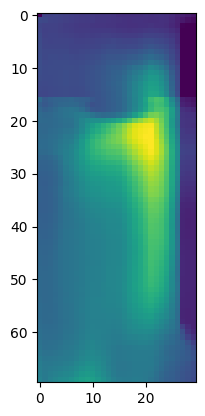

In [30]:
res = response.json()
img = res["result"]
plt.imshow(np.array(img))

#### Get stats

In [32]:
API_TOKEN = ""
# Prepare headers with authorization if API_TOKEN is set
headers = {"Content-Type": "application/json"}
if API_TOKEN and API_TOKEN != "your_api_token_here":
    headers["Authorization"] = f"Bearer {API_TOKEN}"
sample_payload = {
  "result": [
    [0.5, 0.3, 0.7, 0.1],
    [0.2, 0.8, 0.1, 0.9],
    [7.9, 8.4, 9.2, 3.5],
    [2.1, 5.5, 6.8, 7.3]
  ],
  "mask": [
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [1, 1, 1, 1], 
    [1, 1, 1, 1]
  ]
}
response = requests.post(f"{SERVER_URL}/stats", json=sample_payload, headers=headers, timeout=300)
print(response)
print(response.json())

<Response [200]>
{'metrics': {'max': 9.2, 'mean': 3.39375, 'median': 1.5, 'min': 0.1, 'valid_area': 50.0}, 'status': 'success'}


#### Get Window Reference Point

In [33]:
API_TOKEN = ""
# Prepare headers with authorization if API_TOKEN is set
headers = {"Content-Type": "application/json"}
if API_TOKEN and API_TOKEN != "your_api_token_here":
    headers["Authorization"] = f"Bearer {API_TOKEN}"
payload = {
    "room_polygon": [[0, 0], [0, 7], [-3, 7], [-3, 0]],
    "windows": {
        "test_window": {
            "x1": -2, "y1": 7, "z1": 2.8,
            "x2": -0.4, "y2": 7.2, "z2": 5.4,
        }
    }

}
response = requests.post(f"{SERVER_URL}/get-reference-point", json=payload, headers=headers, timeout=300)
print(response)
print(response.json())

<Response [200]>
{'reference_point': {'test_window': {'x': -1.2, 'y': 7.0, 'z': 4.1}}, 'room_polygon': [[0, 0], [0, 7], [-3, 7], [-3, 0]], 'status': 'success', 'windows': {'test_window': {'x1': -2, 'x2': -0.4, 'y1': 7, 'y2': 7.2, 'z1': 2.8, 'z2': 5.4}}}


#### Calculate-direction endpoint

In [34]:
API_TOKEN = ""
# Prepare headers with authorization if API_TOKEN is set
headers = {"Content-Type": "application/json"}
if API_TOKEN and API_TOKEN != "your_api_token_here":
    headers["Authorization"] = f"Bearer {API_TOKEN}"
payload = {
    "room_polygon": [[0, 0], [0, 7], [-3, 7], [-3, 0]],
    "windows": {
        "test_window": {
            "x1": -2, "y1": 7, "z1": 2.8,
            "x2": -0.4, "y2": 7.2, "z2": 5.4,
        }
    }

}
response = requests.post(f"{SERVER_URL}/calculate-direction", json=payload, headers=headers, timeout=300)
print(response)
print(response.json())

<Response [200]>
{'direction_angle': {'test_window': 1.5707963267948966}, 'room_polygon': [[0, 0], [0, 7], [-3, 7], [-3, 0]], 'status': 'success', 'windows': {'test_window': {'x1': -2, 'x2': -0.4, 'y1': 7, 'y2': 7.2, 'z1': 2.8, 'z2': 5.4}}}


#### Calculate obstruction

In [35]:
API_TOKEN = ""
# Prepare headers with authorization if API_TOKEN is set
headers = {"Content-Type": "application/json"}
if API_TOKEN and API_TOKEN != "your_api_token_here":
    headers["Authorization"] = f"Bearer {API_TOKEN}"

# Load sample request
with open("../assets/sample2/window_4952383_request.json", "r") as f:
    obstruction_request = json.load(f)
obstruction_request["mesh"] = obstruction_request["mesh"][:15000]

print(f"Sending request to {SERVER_URL}/obstruction_all")
print(f"Mesh size: {len(obstruction_request['mesh'])} triangles")
print(f"Window position: ({obstruction_request['x']:.2f}, {obstruction_request['y']:.2f}, {obstruction_request['z']:.2f})")

# Send request and time it
start_time = time.time()
response = requests.post(f"{SERVER_URL}/obstruction_all", json=obstruction_request, headers=headers, timeout=300)
elapsed_time = time.time() - start_time

print(f"\nResponse status: {response.status_code}")
print(f"Total time: {elapsed_time:.2f}s")

if response.status_code == 200:
    parallel_result = response.json()
    
    if parallel_result.get("status") == "success":
        try:
            horizon_angles = parallel_result["horizon"]
            zenith_angles = parallel_result["zenith"]
        except Exception:
            # Extract angles from the returned structure
            results = parallel_result.get("data", {}).get("results", [])
            horizon_angles = np.array([r.get("horizon", {}).get("obstruction_angle_degrees", 0.0) for r in results])
            zenith_angles = np.array([r.get("zenith", {}).get("obstruction_angle_degrees", 0.0) for r in results])
        print(f"\n✅ SUCCESS! Calculated obstruction for 64 directions")
        print(f"\nHorizon angles ({len(horizon_angles)} values):")
        
        print(f"\nZenith angles ({len(zenith_angles)} values):")
        obstruction_parallel_result = parallel_result
    else:
        print(f"\n❌ Error: {parallel_result.get('error')}")
else:
    print(f"\n❌ HTTP Error {response.status_code}: {response.text[:200]}")

Sending request to https://api-lux.upskiller.xyz/v2/obstruction_all
Mesh size: 15000 triangles
Window position: (39.98, 48.78, 18.65)

Response status: 200
Total time: 3.28s

✅ SUCCESS! Calculated obstruction for 64 directions

Horizon angles (64 values):

Zenith angles (64 values):


### New obstruction

In [47]:
API_TOKEN = ""
# Prepare headers with authorization if API_TOKEN is set
headers = {"Content-Type": "application/json"}
if API_TOKEN and API_TOKEN != "your_api_token_here":
    headers["Authorization"] = f"Bearer {API_TOKEN}"

# Load sample request
# with open("../assets/sample2/window_4952383_request.json", "r") as f:
#     r = json.load(f)


obstruction_request = {
                "room_polygon": [[0, 0], [0, 7], [-3, 7], [-3, 0]],
                "windows": {
                    
                    "test_window_1": {
                        "x1": -1.0, "y1": 7, "z1": 2.8,
                        "x2": -2, "y2": 7.3, "z2": 5.4,
                        "window_frame_ratio": 0.41,
                        # "direction_angle": 1.5708,
                        # "horizon": [30 for a in horizon_angles],
                        # "zenith": [30 for a in zenith_angles]
                    }
            },
            "mesh": r["mesh"][:150] #[[0,0,0],[0,1,0],[1,0,0]]
        }

# obstruction_request["model_type"] = "df_default_2.0.1"
print(f"Sending request to {SERVER_URL}/obstruction_all")
print(f"Mesh size: {len(obstruction_request['mesh'])} triangles")
# print(f"Window position: ({obstruction_request['x']:.2f}, {obstruction_request['y']:.2f}, {obstruction_request['z']:.2f})")

# Send request and time it
start_time = time.time()
response = requests.post(f"{SERVER_URL}/obstruction_all", json=obstruction_request, headers=headers, timeout=300)
elapsed_time = time.time() - start_time

print(f"\nResponse status: {response.status_code}")
print(f"Total time: {elapsed_time:.2f}s")

if response.status_code == 200:
    res = response.json()
    
    if res.get("status") == "success":
        # Extract angles from the returned structure
        print(res)
    else:
        print(f"\n❌ Error: {parallel_result.get('error')}")
else:
    print(f"\n❌ HTTP Error {response.status_code}: {response.text[:200]}")

Sending request to http://localhost:8080/v2/obstruction_all
Mesh size: 150 triangles

Response status: 200
Total time: 0.88s
{'direction_angle': {'test_window_1': 1.5707963267948966}, 'horizon': {'test_window_1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.689800886702672, 13.11222618382817, 13.512850035752768, 13.891198878387943, 14.2468404411113, 13.799213623063975, 32.50291248931961, 30.542513892997526, 28.45752052236587, 26.24665411960865, 23.9102959925336, 33.720820666784334, 35.574244825762044, 37.30391083131, 32.415695898581276, 26.339477122250234, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, 'mesh': [[77.22627666040614, 82.18868210490075, 5.399999999999942], [105.18636405059453, 74.6444715343351, 5.399999999999942], [105.18636405059453, 74.6444715343351, 32.00000000000007], [105.18636405059453, 74.6444715343351, 32.00000000

#### Encode a window

Sending request to https://api-lux.upskiller.xyz/v2/encode
Mesh size: 1800 triangles

Response status: 200
Total time: 1.86s
Files in zip: ['image.npy', 'mask.npy']


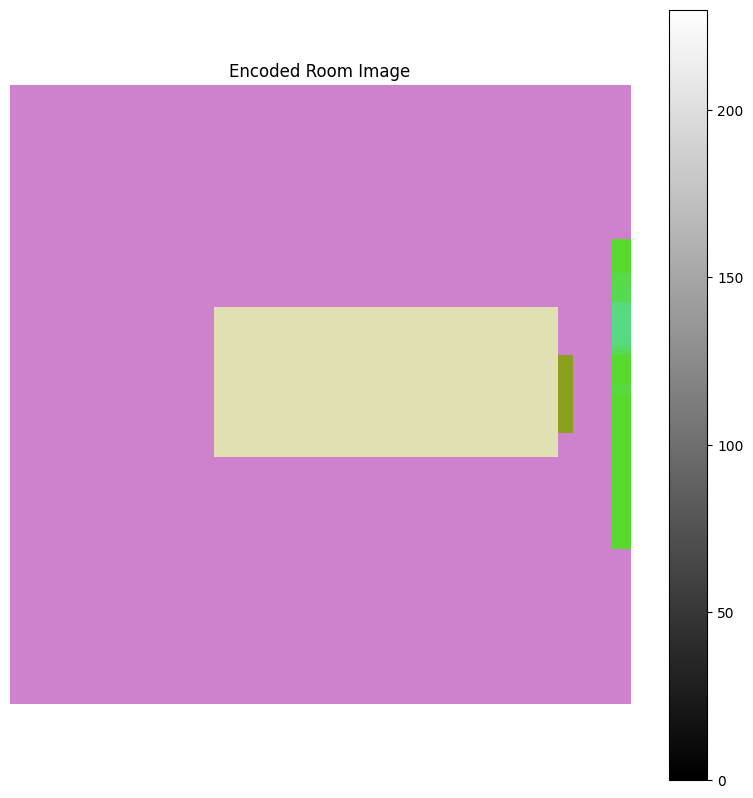

In [36]:
API_TOKEN = ""
# Prepare headers with authorization if API_TOKEN is set
headers = {"Content-Type": "application/json"}
if API_TOKEN and API_TOKEN != "your_api_token_here":
    headers["Authorization"] = f"Bearer {API_TOKEN}"

# Load sample request
with open("../assets/sample2/window_4952383_request.json", "r") as f:
    r = json.load(f)

obstruction_request = {
            "model_type": "df_default", 
            "parameters": {
                "height_roof_over_floor": 19.7,
                "floor_height_above_terrain": 2.71,
                "room_polygon": [[0, 0], [0, 7], [-3, 7], [-3, 0]],
                "windows": {
                    # "test_window": {
                    #     "x1": 0, "y1": 1, "z1": 2.8,
                    #     "x2": 0.4, "y2": 4.8, "z2": 5.4,
                    #     "window_frame_ratio": 0.41,
                    #     # "direction_angle": 0,
                    #     # "horizon": [0 for a in horizon_angles],
                    #     # "zenith": [0 for a in zenith_angles]
                    # }
                    #,
                    "test_window_1": {
                        "x1": -0.4, "y1": 7, "z1": 2.8,
                        "x2": -2, "y2": 7.3, "z2": 5.4,
                        "window_frame_ratio": 0.41
                    }
                }
            },
            "mesh": r["mesh"][:1800]
        }

# obstruction_request["model_type"] = "df_default_2.0.1"
print(f"Sending request to {SERVER_URL}/encode")
print(f"Mesh size: {len(obstruction_request['mesh'])} triangles")
# print(f"Window position: ({obstruction_request['x']:.2f}, {obstruction_request['y']:.2f}, {obstruction_request['z']:.2f})")

# Send request and time it
start_time = time.time()
response = requests.post(f"{SERVER_URL}/encode", json=obstruction_request, headers=headers, timeout=300)
elapsed_time = time.time() - start_time

print(f"\nResponse status: {response.status_code}")
print(f"Total time: {elapsed_time:.2f}s")


if response.status_code == 200:
    # Extract the .npy file from the ZIP
    zip_buffer = BytesIO(response.content)
    
    with zipfile.ZipFile(zip_buffer, 'r') as zip_file:
        # List files in the zip
        print(f"Files in zip: {zip_file.namelist()}")
        
        # Read the image.npy file
        with zip_file.open('image.npy') as npy_file:
            # Load numpy array
            image_array = np.load(npy_file)
            # Display the image
            plt.figure(figsize=(10, 10))
            plt.imshow(image_array, cmap='gray')  # Use cmap='gray' for grayscale
            plt.colorbar()
            plt.title('Encoded Room Image')
            plt.axis('off')
            plt.show()
else:
    print(f"Error: {response.status_code}")
    print(response.text)

Sending request to https://api-lux.upskiller.xyz/v2/encode_raw

Response status: 200
Total time: 0.22s
Files in zip: ['image.npy', 'mask.npy']


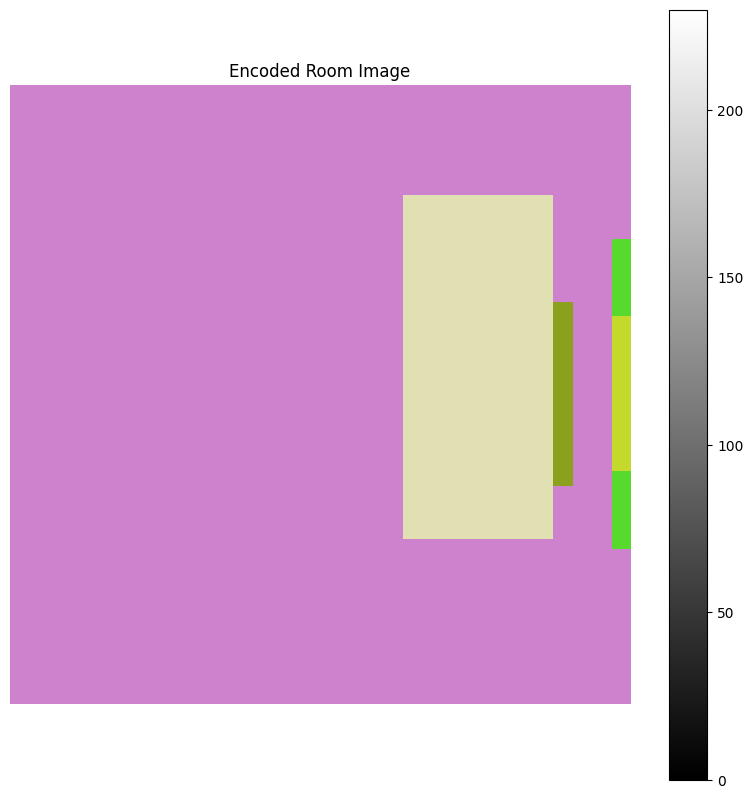

In [37]:
API_TOKEN = ""
# Prepare headers with authorization if API_TOKEN is set
headers = {"Content-Type": "application/json"}
if API_TOKEN and API_TOKEN != "your_api_token_here":
    headers["Authorization"] = f"Bearer {API_TOKEN}"

# Load sample request
with open("../assets/sample2/window_4952383_request.json", "r") as f:
    r = json.load(f)

obstruction_request = {
            "model_type": "df_default", 
            "parameters": {
                "height_roof_over_floor": 19.7,
                "floor_height_above_terrain": 2.71,
                "room_polygon": [[0, 0], [0, 7], [-3, 7], [-3, 0]],
                "windows": {
                    "test_window": {
                        "x1": 0, "y1": 1, "z1": 2.8,
                        "x2": 0.4, "y2": 4.8, "z2": 5.4,
                        "window_frame_ratio": 0.41,
                        "direction_angle": 0,
                        "horizon": [0 for a in horizon_angles],
                        "zenith": [0,60,60,0]
                    }
                    #,
                    # "test_window_1": {
                    #     "x1": -0.4, "y1": 7, "z1": 2.8,
                    #     "x2": -2, "y2": 7.3, "z2": 5.4,
                    #     "window_frame_ratio": 0.41
                    # }
                }
            },
            # "mesh": r["mesh"][:1800]
        }

# obstruction_request["model_type"] = "df_default_2.0.1"
print(f"Sending request to {SERVER_URL}/encode_raw")
# print(f"Mesh size: {len(obstruction_request['mesh'])} triangles")
# print(f"Window position: ({obstruction_request['x']:.2f}, {obstruction_request['y']:.2f}, {obstruction_request['z']:.2f})")

# Send request and time it
start_time = time.time()
response = requests.post(f"{SERVER_URL}/encode_raw", json=obstruction_request, headers=headers, timeout=300)
elapsed_time = time.time() - start_time

print(f"\nResponse status: {response.status_code}")
print(f"Total time: {elapsed_time:.2f}s")


if response.status_code == 200:
    # Extract the .npy file from the ZIP
    zip_buffer = BytesIO(response.content)
    
    with zipfile.ZipFile(zip_buffer, 'r') as zip_file:
        # List files in the zip
        print(f"Files in zip: {zip_file.namelist()}")
        
        # Read the image.npy file
        with zip_file.open('image.npy') as npy_file:
            # Load numpy array
            image_array = np.load(npy_file)
            # Display the image
            plt.figure(figsize=(10, 10))
            plt.imshow(image_array, cmap='gray')  # Use cmap='gray' for grayscale
            plt.colorbar()
            plt.title('Encoded Room Image')
            plt.axis('off')
            plt.show()
else:
    print(f"Error: {response.status_code}")
    print(response.text)